Preguntas:
Imagen
- Codigo fuente o puede ser un colab? puede ser un notebook
- El ADA que tan riguroso debe ser?
- Gradio debo entregar una única app o una por cada instancia? hacer una sola
- Analizar las métricas en la etapa 2
Balancear el dataset
- Comentarios en colab?
- Mails para compartir el repo a los docentes: uso el del campus?
- Para anotación se puede utilizar CVAT?

In [2]:
# 📦 Instalación de paquetes necesarios (solo ejecutar si no están instalados)
!pip install faiss-cpu --quiet
#!pip install albumentations --quiet
#!pip install gradio --quiet

# ⚙️ Librerías estándar
import os
import shutil
import random
from pathlib import Path
from collections import Counter
from tqdm import tqdm

# 📊 Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 🧮 Procesamiento de datos
import numpy as np
import pandas as pd

# 🖼️ Procesamiento de imágenes
from PIL import Image

# 🤖 Frameworks de Deep Learning
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.metrics import ndcg_score

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from torchvision.datasets import ImageFolder

# 🔍 Bases de datos vectoriales
import faiss

# 🎨 Aumentación de datos
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 🌐 Interfaz web
import gradio as gr

# Verificación de versiones
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 72.8 MB/s eta 0:00:00
PyTorch version: 2.6.0+cu124
TensorFlow version: 2.18.0


# Descarga del dataset

In [4]:
import kagglehub
dataset_path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", dataset_path)

df = pd.read_csv(os.path.join(dataset_path,"dogs.csv"))

Path to dataset files: /kaggle/input/70-dog-breedsimage-data-set


In [5]:
df.sample(10)

,filepaths,labels,data set
850,train/Beagle/108.jpg,Beagle,train
2509,train/Chihuahua/062.jpg,Chihuahua,train
5423,train/Labrador/079.jpg,Labrador,train
3703,train/Dingo/020.jpg,Dingo,train
7461,train/Shiba Inu/50.jpg,Shiba Inu,train
8197,test/Clumber/02.jpg,Clumber,test
9222,valid/Poodle/07.jpg,Poodle,valid
3347,train/Corgi/070.jpg,Corgi,train
7560,train/Shih-Tzu/051.jpg,Shih-Tzu,train
4448,train/Great Dane/087.jpg,Great Dane,train


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  9346 non-null   object
 1   labels     9346 non-null   object
 2   data set   9346 non-null   object
dtypes: object(3)
memory usage: 219.2+ KB


In [7]:
# se normalizan los títulos de las raza porque me aparecían demás.
df["labels"] = df["labels"].str.strip()
df["labels"] = df["labels"].str.replace(r"\s+", " ", regex=True)  # Normaliza espacios múltiples
df["labels"] = df["labels"].str.title()  # Estandariza mayúsculas
unique_labels = df["labels"].unique()
print(sorted(unique_labels))

['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


In [8]:
dataset_path_train = dataset_path+'/train'
class_number = len(os.listdir(dataset_path_train))

In [9]:
class_number

70

# EDA

In [10]:
# Obtener todas las clases (carpetas)
clases = [d for d in os.listdir(dataset_path_train) if os.path.isdir(os.path.join(dataset_path_train, d))]

# Contar archivos por clase
conteo = []
for clase in clases:
    carpeta = os.path.join(dataset_path_train, clase)
    archivos = [f for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))]
    conteo.append({
        "Clase": clase,
        "Cantidad": len(archivos)
    })

# Crear DataFrame
df_clases = pd.DataFrame(conteo).sort_values(by="Cantidad", ascending=False)

# Mostrar tabla
#display(df_clases)

# Calcular los quartiles
q1 = df_clases['Cantidad'].quantile(0.25)
q2 = df_clases['Cantidad'].quantile(0.5)  # Mediana
q3 = df_clases['Cantidad'].quantile(0.75)

print(f"Q1 (25% inferior): {q1:.0f} imágenes por clase")
print(f"Q2 (Mediana): {q2:.0f} imágenes por clase")
print(f"Q3 (75% superior): {q3:.0f} imágenes por clase")
print(f"Máximo: {df_clases['Cantidad'].max():.0f} imágenes por clase")
print(f"Mínimo: {df_clases['Cantidad'].min():.0f} imágenes por clase")

# Gráfico interactivo con Plotly
fig = px.bar(
    df_clases,
    x='Clase',
    y='Cantidad',
    title='Cantidad de ejemplos por clase',
    text='Cantidad',
    color='Clase'
)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()


Q1 (25% inferior): 99 imágenes por clase
Q2 (Mediana): 112 imágenes por clase
Q3 (75% superior): 125 imágenes por clase
Máximo: 198 imágenes por clase
Mínimo: 65 imágenes por clase


Se puede observar un claro desbalance con clases que tienen menos ejemplos.

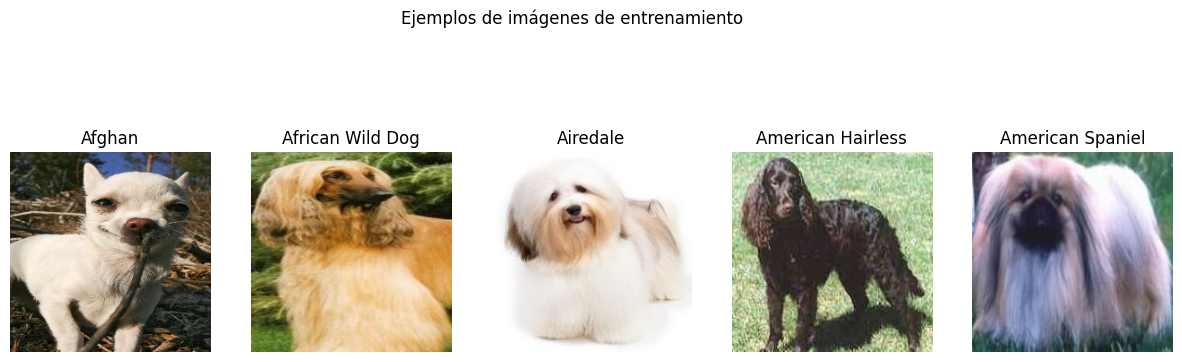


Tamaño promedio de las imágenes (train): (224, 224) (ancho x alto)


In [11]:
# Ejemplos visuales
sample_df = df[df["data set"] == "train"].groupby("labels").head(1)  # 1 imagen por clase
sample_paths = sample_df.sample(5, random_state=42)["filepaths"].values

plt.figure(figsize=(15, 5))
for i, path_str in enumerate(sample_paths):
    img = Image.open(dataset_path +'/' +path_str)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(sample_df.iloc[i]['labels'])
    plt.axis("off")
plt.suptitle("Ejemplos de imágenes de entrenamiento")
plt.show()

# Tamaño promedio de imágenes (muestra de 100)
sample_img_paths = df[df["data set"] == "train"]["filepaths"].sample(100, random_state=42).values
sizes = []
for img_path in sample_img_paths:
    with Image.open(dataset_path +'/' +img_path) as img:
        sizes.append(img.size)

widths, heights = zip(*sizes)
avg_size = (sum(widths) // len(widths), sum(heights) // len(heights))
print(f"\nTamaño promedio de las imágenes (train): {avg_size} (ancho x alto)")


## Balanceo del Dataset

Dado el desbalance del dataset, se opta por aplicar un balanceo simple. Se aumentarán las clases minoritarias.

In [14]:
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

target_count_per_class = int(q2) # Convert to int

max_count_per_class = q3

print(f"Objetivo de imágenes por clase (mínimo): {target_count_per_class}")
print(f"Máximo de imágenes por clase para undersampling: {max_count_per_class}")

# --- Create a new directory for the balanced dataset ---
balanced_train_data_path = "/kaggle/working/train_balanced"  # Changed to /kaggle/working/
#balanced_train_data_path = os.path.join(dataset_path, "train_balanced")
os.makedirs(balanced_train_data_path, exist_ok=True)

# --- Process each class for oversampling and undersampling ---
for index, row in df_clases.iterrows():
    class_name = row['Clase']
    current_count = row['Cantidad']

    original_class_dir = os.path.join(dataset_path_train, class_name)
    balanced_class_dir = os.path.join(balanced_train_data_path, class_name)
    os.makedirs(balanced_class_dir, exist_ok=True)

    images = [f for f in os.listdir(original_class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # --- Oversampling: If current count is below the target, generate new images ---
    if current_count < target_count_per_class:
        images_to_generate = target_count_per_class - current_count
        print(f"[{class_name}] Minoria: Generando {images_to_generate} imágenes (de {current_count} a {target_count_per_class}).")

        # Copy original images first
        for img_name in images:
            shutil.copy(os.path.join(original_class_dir, img_name), balanced_class_dir)

        # Generate augmented images until target is met
        original_images_for_augmentation = [Image.open(os.path.join(original_class_dir, img_name)).convert("RGB") for img_name in images]

        generated_count = 0
        while generated_count < images_to_generate:
            for original_img in original_images_for_augmentation:
                if generated_count >= images_to_generate:
                    break
                augmented_img = augmentation_transform(original_img)
                # Save the augmented image
                augmented_img.save(os.path.join(balanced_class_dir, f"aug_{class_name}_{generated_count}_{random.randint(0, 10000)}.jpg"))
                generated_count += 1

    # --- Undersampling: If current count is significantly above the max target, remove some ---
    # IMPORTANT: Undersampling removes actual data. Use with caution.
    # We'll copy up to max_count_per_class images (a mix of existing ones)
    elif current_count > max_count_per_class:
        print(f"[{class_name}] Mayoria: Recortando imágenes (de {current_count} a {max_count_per_class}).")
        # Randomly select images to copy to the new balanced directory
        random.shuffle(images) # Shuffle to get a random subset
        for i in range(int(min(len(images), max_count_per_class))):
            shutil.copy(os.path.join(original_class_dir, images[i]), balanced_class_dir)

    # --- For classes within the desired range (target_count_per_class to max_count_per_class) or slightly above ---
    # Just copy the original images as is
    else:
        print(f"[{class_name}] Balanceado: Copiando {current_count} imágenes originales.")
        for img_name in images:
            shutil.copy(os.path.join(original_class_dir, img_name), balanced_class_dir)


print(f"\nDataset de entrenamiento balanceado creado en: {balanced_train_data_path}")

# --- Verify new counts ---
print("\nConteo de clases después del balanceo:")
new_class_counts = {}
for class_name in os.listdir(balanced_train_data_path):
    class_dir = os.path.join(balanced_train_data_path, class_name)
    if os.path.isdir(class_dir):
        new_class_counts[class_name] = len(os.listdir(class_dir))

print(f'clases luego del balance {len(os.listdir(balanced_train_data_path))}')
for cls, count in sorted(new_class_counts.items(), key=lambda item: item[1]):
    print(f"- {cls}: {count} imágenes")

Objetivo de imágenes por clase (mínimo): 111
Máximo de imágenes por clase para undersampling: 125.0
[Shih-Tzu] Mayoria: Recortando imágenes (de 198 a 125.0).
[Lhasa] Mayoria: Recortando imágenes (de 187 a 125.0).
[Labrador] Mayoria: Recortando imágenes (de 161 a 125.0).
[Basset] Mayoria: Recortando imágenes (de 159 a 125.0).
[Scotch Terrier] Mayoria: Recortando imágenes (de 150 a 125.0).
[Pomeranian] Mayoria: Recortando imágenes (de 149 a 125.0).
[Pug] Mayoria: Recortando imágenes (de 148 a 125.0).
[Bloodhound] Mayoria: Recortando imágenes (de 147 a 125.0).
[Boxer] Mayoria: Recortando imágenes (de 134 a 125.0).
[Bermaise] Mayoria: Recortando imágenes (de 131 a 125.0).
[Pit Bull] Mayoria: Recortando imágenes (de 130 a 125.0).
[Cocker] Mayoria: Recortando imágenes (de 130 a 125.0).
[Cockapoo] Mayoria: Recortando imágenes (de 129 a 125.0).
[Dingo] Mayoria: Recortando imágenes (de 129 a 125.0).
[Maltese] Mayoria: Recortando imágenes (de 129 a 125.0).
[Bull Mastiff] Mayoria: Recortando imág

# Embeddings

In [18]:
# Your existing setup
df_train = df[df["data set"] == "train"].reset_index(drop=True)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
keras_embedding_model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D()
])

def load_and_preprocess_image(img_path):
    img = Image.open(dataset_path +'/'+ img_path).convert("RGB").resize((224, 224))
    x = img_to_array(img)  # Fixed this line
    x = np.expand_dims(x, axis=0)
    return preprocess_input(x)


if not os.path.exists("dog_embeddings_resnet50.npz"):
    # Initialize empty lists
  embeddings = []
  labels = []
  filepaths = []

  for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
      try:
          img_array = load_and_preprocess_image(row["filepaths"])
          embedding = keras_embedding_model.predict(img_array, verbose=0)
          embeddings.append(embedding.flatten())
          labels.append(row["labels"])
          filepaths.append(row["filepaths"])
      except Exception as e:
          print(f"Error with {row['filepaths']}: {e}")

  embeddings = np.array(embeddings)
  labels = np.array(labels)
  filepaths = np.array(filepaths)

  # Save to compressed .npz file
  np.savez("dog_embeddings_resnet50.npz", embeddings=embeddings, labels=labels, filepaths=filepaths)
  print("Embeddings saved to dog_embeddings_resnet50.npz")
else:
  data = np.load("dog_embeddings_resnet50.npz", allow_pickle=True)
  embeddings = data["embeddings"]
  labels = data["labels"]
  filepaths = data["filepaths"]
  print("Embeddings loaded from dog_embeddings_resnet50.npz")

Embeddings loaded from dog_embeddings_resnet50.npz


## Base de Datos Vectorial

In [19]:
# Normalizar embeddings (opcional pero recomendado para similitud coseno)
faiss.normalize_L2(embeddings)

# Crear el índice FAISS (utiliza L2 con vectores normalizados ≈ coseno)
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)  # IP = inner product
index.add(embeddings)

print(f"Índice FAISS creado con {index.ntotal} vectores.")

Índice FAISS creado con 7946 vectores.


In [20]:
def get_embedding(img: Image.Image):
    img = img.convert("RGB").resize((224, 224))
    x = keras_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = keras_embedding_model.predict(x, verbose=0)
    embedding = embedding.flatten().reshape(1, -1).astype(np.float32)
    faiss.normalize_L2(embedding)
    return embedding

def buscar_similares(img: Image.Image):
    query_embedding = get_embedding(img)
    D, I = index.search(query_embedding, k=10)

    resultados = []
    razas = []

    for idx in I[0]:
        path_img = os.path.join(dataset_path, filepaths[idx])
        raza = labels[idx]
        resultados.append(Image.open(path_img).resize((224, 224)))
        razas.append(raza)

    # Voto mayoritario
    pred_raza = Counter(razas).most_common(1)[0][0]

    return resultados, pred_raza
# Interfaz Gradio
def interfaz_gradio(img):
    imagenes, pred_raza = buscar_similares(img)
    return imagenes, f"Raza estimada: {pred_raza}"

gr.Interface(
    fn=interfaz_gradio,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Gallery(label="Imágenes Similares", columns=5, height="auto"),
        gr.Textbox(label="Predicción")
    ],
    title="Buscador de Razas de Perros por Similitud",
    description="Subí una imagen de un perro y encuentra las 10 más similares del dataset."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0df25bb68181c69dea.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Etapa 2

In [21]:
resnet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

num_classes = 70 # replace with the number of classes in your dataset
resnet18_model.fc = torch.nn.Linear(resnet18_model.fc.in_features, num_classes)


# Check if GPU (CUDA) is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.6MB/s]


Using device: cuda


In [27]:
# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load the train and validation datasets
train_dataset = ImageFolder(balanced_train_data_path, transform=transform)
val_dataset = ImageFolder('/kaggle/input/70-dog-breedsimage-data-set/valid', transform=transform)
test_dataset = ImageFolder('/kaggle/input/70-dog-breedsimage-data-set/test', transform=transform)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_model.fc.parameters(), lr=0.01, momentum=0.9)
pytorch_classifier_model = resnet18_model.to(device)

In [28]:
def train(model_to_train, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model_to_train = model_to_train.to(device)

    # Inicializar las métricas como atributos del modelo
    model_to_train.train_metrics = {'loss': [], 'acc': []}
    model_to_train.val_metrics = {'loss': [], 'acc': []}

    for epoch in range(num_epochs):
        model_to_train.train()
        running_loss = 0.0
        running_corrects = 0

        # Fase de entrenamiento
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model_to_train(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calcular métricas de entrenamiento
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.float() / len(train_loader.dataset)
        model_to_train.train_metrics['loss'].append(epoch_train_loss)
        model_to_train.train_metrics['acc'].append(epoch_train_acc.item())

        # Fase de validación
        model_to_train.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model_to_train(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        # Calcular métricas de validación
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.float() / len(val_loader.dataset)
        model_to_train.val_metrics['loss'].append(epoch_val_loss)
        model_to_train.val_metrics['acc'].append(epoch_val_acc.item())

        # Mostrar progreso
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}')

    # Guardar el modelo completo (no solo state_dict) para preservar las métricas
    torch.save({
        'model_state_dict': model_to_train.state_dict(),
        'train_metrics': model_to_train.train_metrics,
        'val_metrics': model_to_train.val_metrics
    }, 'dog_breed_classifier.pth')

# Cargar o entrenar el modelo
if os.path.exists('dog_breed_classifier.pth'):
    checkpoint = torch.load('dog_breed_classifier.pth')
    pytorch_classifier_model.load_state_dict(checkpoint['model_state_dict'])

    # Restaurar las métricas
    pytorch_classifier_model.train_metrics = checkpoint['train_metrics']
    pytorch_classifier_model.val_metrics = checkpoint['val_metrics']

    print("Modelo cargado desde dog_breed_classifier.pth")
    print("\nMétricas guardadas en el modelo:")
    print("Última epoch de entrenamiento:")
    print(f"Train loss: {pytorch_classifier_model.train_metrics['loss'][-1]:.4f}")
    print(f"Train accuracy: {pytorch_classifier_model.train_metrics['acc'][-1]:.4f}")
    print(f"Val loss: {pytorch_classifier_model.val_metrics['loss'][-1]:.4f}")
    print(f"Val accuracy: {pytorch_classifier_model.val_metrics['acc'][-1]:.4f}")
else:
    train(pytorch_classifier_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10] - Train Loss: 0.3440, Acc: 0.8982 | Val Loss: 0.5828, Acc: 0.9157
Epoch [2/10] - Train Loss: 0.2851, Acc: 0.9190 | Val Loss: 0.6176, Acc: 0.9000
Epoch [3/10] - Train Loss: 0.2503, Acc: 0.9307 | Val Loss: 0.6262, Acc: 0.9129
Epoch [4/10] - Train Loss: 0.2281, Acc: 0.9326 | Val Loss: 0.6531, Acc: 0.9086
Epoch [5/10] - Train Loss: 0.2050, Acc: 0.9395 | Val Loss: 0.6284, Acc: 0.9129
Epoch [6/10] - Train Loss: 0.1934, Acc: 0.9438 | Val Loss: 0.6629, Acc: 0.8986
Epoch [7/10] - Train Loss: 0.1744, Acc: 0.9485 | Val Loss: 0.6503, Acc: 0.9014
Epoch [8/10] - Train Loss: 0.1638, Acc: 0.9562 | Val Loss: 0.6555, Acc: 0.9114
Epoch [9/10] - Train Loss: 0.1529, Acc: 0.9573 | Val Loss: 0.6674, Acc: 0.9200
Epoch [10/10] - Train Loss: 0.1475, Acc: 0.9591 | Val Loss: 0.6476, Acc: 0.9157


In [31]:
def evaluate_ndcg(model_type="resnet50"):
    """
    Evalúa el sistema de búsqueda por similitud usando NDCG@10.
    model_type: "resnet50" (embeddings pre-entrenados) o "resnet18" (fine-tuned)
    """
    # Configuración inicial
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_dir = os.path.join(dataset_path, "test")

    # 1. Cargar el dataset de test
    test_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    test_image_paths = []
    test_labels = []

    for class_name in test_classes:
        class_dir = os.path.join(test_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        test_image_paths.extend([os.path.join(class_dir, img) for img in images])
        test_labels.extend([class_name]*len(images))

    print(f"Total imágenes de test: {len(test_image_paths)}")

    # 2. Preparar el modelo para extraer embeddings
    if model_type == "resnet18":
        embedding_model = torch.nn.Sequential(*list(pytorch_classifier_model.children())[:-1])
        embedding_model.eval().to(device)
        transform_fn = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        embedding_model = keras_embedding_model
        transform_fn = lambda img: preprocess_input(
            np.expand_dims(keras_image.img_to_array(img.resize((224, 224))), axis=0))

    # 3. Generar embeddings
    test_embeddings = []
    for img_path in tqdm(test_image_paths, desc=f"Generando embeddings ({model_type})"):
        img = Image.open(img_path).convert("RGB")

        if model_type == "resnet18":
            img_tensor = transform_fn(img).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = embedding_model(img_tensor).flatten().cpu().numpy()
        else:
            img_array = transform_fn(img)
            embedding = embedding_model.predict(img_array, verbose=0).flatten()

        test_embeddings.append(embedding)

    test_embeddings = np.array(test_embeddings).astype(np.float32)
    faiss.normalize_L2(test_embeddings)

    # 4. Crear índice FAISS
    d = test_embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(test_embeddings)

    # 5. Calcular NDCG@10
    ndcg_scores = []
    for i in tqdm(range(len(test_image_paths)), desc="Calculando NDCG@10"):
        query_label = test_labels[i]

        # Buscar 11 vecinos (el primero será la propia imagen)
        _, I = index.search(test_embeddings[i:i+1], k=11)

        # Calcular relevancia
        relevance = np.zeros(10)
        for j, idx in enumerate(I[0][1:11]):  # Tomar 10 vecinos más cercanos (excluyendo el primero)
            relevance[j] = 1 if test_labels[idx] == query_label else 0

        # Solo calcular si hay resultados relevantes
        if np.sum(relevance) > 0:
            ideal_relevance = np.sort(relevance)[::-1]  # Orden descendente
            ndcg = ndcg_score([ideal_relevance], [relevance], k=10)
            ndcg_scores.append(ndcg)

    # 6. Resultados
    if len(ndcg_scores) == 0:
        print("¡Advertencia! No se encontraron resultados relevantes para calcular NDCG")
        return 0.0

    mean_ndcg = np.mean(ndcg_scores)
    std_ndcg = np.std(ndcg_scores)

    print(f"\nResultados ({model_type.upper()}):")
    print(f"- NDCG@10 promedio: {mean_ndcg:.4f}")
    print(f"- Desviación estándar: {std_ndcg:.4f}")
    print(f"- Imágenes evaluadas: {len(ndcg_scores)}")

    return mean_ndcg
# Evaluar ambos modelos
print("\n" + "="*50)
print("Evaluando con ResNet50 (embeddings pre-entrenados)")
ndcg_resnet50 = evaluate_ndcg("resnet50")

print("\n" + "="*50)
print("Evaluando con ResNet18 (fine-tuned)")
ndcg_resnet18 = evaluate_ndcg("resnet18")

# Comparación final
print("\n" + "="*50)
print("Comparación final:")
print(f"- ResNet50 NDCG@10: {ndcg_resnet50:.4f}")
print(f"- ResNet18 NDCG@10: {ndcg_resnet18:.4f}")
print(f"- Mejora relativa: {((ndcg_resnet18 - ndcg_resnet50)/ndcg_resnet50)*100:.2f}%")


Evaluando con ResNet50 (embeddings pre-entrenados)
Total imágenes de test: 700


Calculando NDCG@10: 100%|██████████| 700/700 [00:00<00:00, 1150.05it/s]



Resultados (RESNET50):
- NDCG@10 promedio: 0.8955
- Desviación estándar: 0.1179
- Imágenes evaluadas: 697

Evaluando con ResNet18 (fine-tuned)
Total imágenes de test: 700


Calculando NDCG@10: 100%|██████████| 700/700 [00:00<00:00, 1191.81it/s]


Resultados (RESNET18):
- NDCG@10 promedio: 0.8715
- Desviación estándar: 0.1341
- Imágenes evaluadas: 695

Comparación final:
- ResNet50 NDCG@10: 0.8955
- ResNet18 NDCG@10: 0.8715
- Mejora relativa: -2.68%


In [37]:
def setup_resnet18_embeddings():
    """Carga o genera los embeddings para ResNet18 y devuelve todo lo necesario"""
    try:
        # Intentar cargar datos precalculados
        data = np.load("resnet18_train_embeddings.npz")
        print("Embeddings de ResNet18 cargados desde archivo")
        return data["embeddings"], data["paths"], data["classes"]
    except:
        print("Generando embeddings de entrenamiento con ResNet18...")

        # Configurar el extractor de características
        feature_extractor = torch.nn.Sequential(*list(pytorch_classifier_model.children())[:-1])
        feature_extractor.eval().to(device)

        embeddings = []
        paths = []
        classes = []

        # Procesar dataset de entrenamiento
        for img_path, class_idx in tqdm(train_dataset.imgs, desc="Procesando imágenes"):
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img).unsqueeze(0).to(device)

                with torch.no_grad():
                    embedding = feature_extractor(img_tensor).flatten().cpu().numpy()
                    embeddings.append(embedding)
                    paths.append(img_path)
                    classes.append(train_dataset.classes[class_idx])
            except Exception as e:
                print(f"Error procesando {img_path}: {str(e)}")
                continue

        # Convertir a arrays numpy y guardar
        embeddings = np.array(embeddings).astype(np.float32)
        np.savez("resnet18_train_embeddings.npz",
                embeddings=embeddings,
                paths=paths,
                classes=classes)

        return embeddings, paths, classes

# Cargar/generar embeddings y crear índice FAISS
resnet18_embeddings, resnet18_paths, resnet18_classes = setup_resnet18_embeddings()
resnet18_index = faiss.IndexFlatIP(resnet18_embeddings.shape[1])
faiss.normalize_L2(resnet18_embeddings)
resnet18_index.add(resnet18_embeddings)

def predict_with_resnet18(img: Image.Image):
    """Predice la raza y encuentra imágenes similares usando ResNet18"""
    try:
        # Configurar extractor de características
        feature_extractor = torch.nn.Sequential(*list(pytorch_classifier_model.children())[:-1])
        feature_extractor.eval().to(device)

        # Procesar imagen de entrada
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            # Extraer características y predecir clase
            embedding = feature_extractor(img_tensor).flatten().cpu().numpy()
            embedding = embedding.reshape(1, -1).astype(np.float32)
            faiss.normalize_L2(embedding)

            outputs = pytorch_classifier_model(img_tensor)
            _, preds = torch.max(outputs, 1)
            predicted_class = train_dataset.classes[preds[0]]

            # Buscar imágenes similares
            _, indices = resnet18_index.search(embedding, k=10)
            similar_images = [Image.open(resnet18_paths[i]).resize((224, 224)) for i in indices[0]]
            similar_classes = [resnet18_classes[i] for i in indices[0]]

            # Formatear resultado
            result_text = f"Raza estimada: {predicted_class}\n\nRazas en imágenes similares:\n"
            result_text += "\n".join(f"{i+1}. {cls}" for i, cls in enumerate(similar_classes))

            return result_text, similar_images

    except Exception as e:
        print(f"Error en predict_with_resnet18: {str(e)}")
        return "Error al procesar la imagen", []

def predict_with_model(image: Image.Image, model_choice: str):
    """Función unificada para Gradio que maneja ambos modelos"""
    try:
        if model_choice == "ResNet18 Fine-Tuned":
            return predict_with_resnet18(image)
        else:
            images, pred = buscar_similares(image)
            return f"Raza estimada: {pred}", images
    except Exception as e:
        print(f"Error en predict_with_model: {str(e)}")
        return "Error al procesar la imagen", []
# # Función de switch (igual que antes pero ahora ambos métodos muestran imágenes)
# def predict_switch(image: Image.Image, use_resnet18: bool):
#     if use_resnet18:
#         return predict_with_resnet18(image)
#     else:
#         imagenes, pred_raza = buscar_similares(image)
#         return f"Raza estimada (por similitud): {pred_raza}", imagenes



Generando embeddings de entrenamiento con ResNet18...


Procesando imágenes: 100%|██████████| 8151/8151 [00:44<00:00, 183.62it/s]


In [39]:
interface = gr.Interface(
    fn=predict_with_model,
    inputs=[
        gr.Image(type="pil", label="Imagen del perro"),
        gr.Dropdown(
            choices=["ResNet50 Pre-entrenado", "ResNet18 Fine-Tuned"],
            value="ResNet50 Pre-entrenado",
            label="Modelo de clasificación"
        )
    ],
    outputs=[
        gr.Textbox(label="Resultado"),
        gr.Gallery(label="Imágenes similares", columns=5)
    ],
    title="🐶 Clasificador de Razas Caninas",
    description="Seleccione un modelo y suba una imagen para identificar la raza del perro"
)

# Lanzar la interfaz
print("¡Interfaz lista! Acceda a la URL que aparecerá a continuación")
interface.launch()

¡Interfaz lista! Acceda a la URL que aparecerá a continuación
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9a937a46bbffb7fd00.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
